Loads definitions and ignores those with no age assigned. A manually lemmatized version of the definitions is available and I work directly with it.

Age median: 12.0


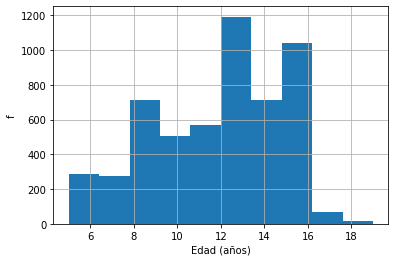

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
cesca_all = pd.read_csv('cesca/definitions.csv')
cesca_filtered = cesca_all.dropna(axis=0, subset=['age', 'lemmatized'])  # removes rows with na in either age or lemmatized fields
cesca_filtered = cesca_filtered[cesca_filtered['age'] > 0].reset_index(drop=True)  # removes rows with age == 0
# some usage comments: dropna and reset_index return new objects, unless 'inplace' is specified
cesca_filtered.title = cesca_filtered.title.apply(str.lstrip)  # removes leading whitespaces
age_hist = cesca_filtered.age.hist()
age_hist.set_xlabel('Edad (años)')
age_hist.set_ylabel('f')
# cesca_filtered.age.hist(by=cesca_filtered.title)
print('Age median: ' + str(np.median(cesca_filtered.age)))

In [3]:
# Are titles lemmatized? Do they appear in the lemmatized version of the definitions?
lemmas = []
for lemmatized in cesca_filtered.lemmatized:
    for lemma in lemmatized.split():
        lemmas.append(lemma)
lemmas = set(lemmas)
for title in cesca_filtered.title.unique():
    if title not in lemmas:
        print(title + ' not in lemmas!')

gent gran not in lemmas!
espantar-se not in lemmas!


In [4]:
# replace titles not in lemmatized definitions with a lemmatized version
lemmatized_titles = cesca_filtered.title.copy()
lemmatized_titles[lemmatized_titles == 'gent gran'] = 'gent_gran'  # 'gent_gran' is however not a lemma in lemmatized definitions either;
lemmatized_titles[lemmatized_titles == 'espantar-se'] = 'espantar'  # 'espantar' is, indeed, a lemma in lemmatized definitions

# and add lemmatized titles at the beginning of the lemmatized definitions
cesca_filtered['lemmatized'] = lemmatized_titles + ' ' + cesca_filtered['lemmatized']

In [5]:
# loads list of stopwords
with open('ca_stop3_custom') as stop_ca:
    for row in stop_ca:
        if not row.startswith('#'):
            row = row[:-1]  # drops newline character at the end of the line
            stoplist = row.split(', ')
stoplist = set(stoplist)

In [6]:
# splits dataframe in two by age
young_range = (0,11)
older_range = (12,99)
def split_by_age(df, young_range, older_range):
    cesca_young = df[(df.age >= young_range[0]) & (df.age <= young_range[1])]
    cesca_older = df[(df.age >= older_range[0]) & (df.age <= older_range[1])]
    return cesca_young, cesca_older

cesca_young, cesca_older = split_by_age(cesca_filtered, young_range, older_range)
print('Younger group has {} definitions, while older has {}.'.format(len(cesca_young), len(cesca_older)))

Younger group has 2352 definitions, while older has 3029.


In [7]:
# from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text
TfidfVectorizer = sklearn.feature_extraction.text.TfidfVectorizer
from copy import copy, deepcopy

def tokenizer(string):
    # if left to the CountVectorizer's default tokenizer, it splits words with pont volat
    tokens = [token for token in string.split() if len(token) > 1]  # it only keeps tokens longer than one character
    #tokens = [token for token in string.replace('_', ' ').split() if len(token) > 1]  # this breaks 2+gram lemmas with underscores,
                                                                                       # but it may not be the best choice as they
                                                                                       # were manually annotated
    return tokens

# as opposed to CountVectorizer, TfidfVectorizer normalizes by default
vectorizer_young = TfidfVectorizer(
                                   binary=False,  # very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable
                                   lowercase=False,
                                   max_df=1.0,  # ignore terms with document frequency higher than this threshold
                                   min_df=3,  # ignore terms with document frequency lower than threshold
                                   preprocessor=None,  # override the preprocessing step
                                   tokenizer=tokenizer,  # override the tokenizer step; wouldn't override the ngram_range parameter
                                   ngram_range=(1,1),  # extract n-grams
                                   stop_words=stoplist,  # list of stopwords
                                   strip_accents=None,
                                   token_pattern='',  # The default regexp selects tokens of 2 or more alphanumeric characters (punctuation is completely ignored);
                                                      # should be overriden by custom tokenizer
                                   use_idf = True,
                                   norm = 'l2', # disable normalization and idf to get same results as with CountVectorizer
                                   )
vectorizer_older = deepcopy(vectorizer_young)

tfidf_young = vectorizer_young.fit_transform(cesca_young.lemmatized)
tfidf_older = vectorizer_older.fit_transform(cesca_older.lemmatized)

print('Young vocabulary has {} tokens, including bi- and trigrams if applicable.'.format(len(vectorizer_young.get_feature_names())))
print('Older vocabulary has {} tokens, including bi- and trigrams if applicable.'.format(len(vectorizer_older.get_feature_names())))

Young vocabulary has 512 tokens, including bi- and trigrams if applicable.
Older vocabulary has 854 tokens, including bi- and trigrams if applicable.


In [8]:
# LSA dimensionality reduction

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

n_components = 50  # 100 is recommended number of components in SKLearn documentation
                    # Gensim recommends 200-500
svd_young = TruncatedSVD(n_components)
normalizer_young = Normalizer(copy=False)  # rescale each row/doc so that its norm (l2-norm by default) equals to one
lsaer_young = make_pipeline(svd_young, normalizer_young)

svd_older = deepcopy(svd_young)
normalizer_older = deepcopy(normalizer_young)
lsaer_older = make_pipeline(svd_older, normalizer_older)

lsa_young = lsaer_young.fit_transform(tfidf_young)
lsa_older = lsaer_older.fit_transform(tfidf_older)

print('Explained variance of the SVD step:')
print('Young group: {}%'.format(svd_young.explained_variance_.sum() * 100))
print('Older group: {}%'.format(svd_older.explained_variance_.sum() * 100))

Explained variance of the SVD step:
Young group: 45.01736574606577%
Older group: 38.15392276933423%


In [9]:
# one set of features from young and older vectorizers; intersection
features_all = set(vectorizer_young.get_feature_names()).intersection(vectorizer_older.get_feature_names())
# Warning: this set should be used in all shuffling steps, given that the features in each vectorizer may not be
# exactly the same (e.g. it may happen that some feature appears only once in one of the random young/older subsets
# and is thus ignored)
features_all = sorted(list(features_all))  # sort features alphabetically

In [57]:
def get_similarities(features, vectorizer_young, vectorizer_older, lsaer_young, lsaer_older):
    from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
    from scipy.stats import spearmanr
        
    features_tfidf_young = vectorizer_young.transform(features)
    features_lsa_young = lsaer_young.transform(features_tfidf_young)
    empty_young = [feature not in vectorizer_young.get_feature_names() for feature in features]  # logical indices of features not in vocabulary
    
    features_tfidf_older = vectorizer_older.transform(features)
    features_lsa_older = lsaer_older.transform(features_tfidf_older)
    empty_older = [feature not in vectorizer_older.get_feature_names() for feature in features]
    
    similarity_young = cosine_similarity(features_lsa_young)  # On L2-normalized data, this function is equivalent to linear_kernel
    # clears distances which involve features not in the vocabulary
    # this is needed for shuffled data as feature intersection (features_all) is obtained only once
    similarity_young[empty_young, :] = np.nan
    similarity_young[:, empty_young] = np.nan
    
    similarity_older = cosine_similarity(features_lsa_older)
    similarity_older[empty_older, :] = np.nan
    similarity_older[:, empty_older] = np.nan
    
    # for each pair of lemmas, it calculates the distance (between lemmas) difference between both groups (young and older)
    similarity_delta = similarity_older - similarity_young
    
    return similarity_young, similarity_older, similarity_delta

similarity_young, similarity_older, similarity_delta = get_similarities(features_all,
                                                                        vectorizer_young, vectorizer_older,
                                                                        lsaer_young, lsaer_older)

In [58]:
# Apparently, it is not obvious that measurements of distance can be
# compared between vector/semantic spaces.
# Are distributions of distances comparable between corpuses/age-groups?
print('Young: {} ± {}'.format(np.mean(similarity_young), np.std(similarity_young)))
print('Older: {} ± {}'.format(np.mean(similarity_older), np.std(similarity_older)))

Young: 0.029524682038387266 ± 0.15940152854377468
Older: 0.02938738226089422 ± 0.1608434571461749


In [65]:
iter = 1000
similarity_deltas = []
similarity_correlations = []

# copy vectorizers and lsaers for iterations, to keep original fits with unshuffled data
vectorizer_young_shuffle = deepcopy(vectorizer_young)
vectorizer_older_shuffle = deepcopy(vectorizer_older)

svd_young_shuffle = deepcopy(svd_young)
normalizer_young_shuffle = deepcopy(normalizer_young)
lsaer_young_shuffle = make_pipeline(svd_young_shuffle, normalizer_young_shuffle)

svd_older_shuffle = deepcopy(svd_older)
normalizer_older_shuffle = deepcopy(normalizer_older)
lsaer_older_shuffle = make_pipeline(svd_older_shuffle, normalizer_older_shuffle)

for i in range(iter):
    print(i)
    cesca_shuffled = cesca_filtered.copy()
    cesca_shuffled.age = cesca_shuffled.age.sample(frac=1).reset_index(drop=True)  # shuffles ages
    young_shuffled, older_shuffled = split_by_age(cesca_shuffled, young_range, older_range)
    
    tfidf_young_shuffle = vectorizer_young_shuffle.fit_transform(young_shuffled.lemmatized)
    tfidf_older_shuffle = vectorizer_older_shuffle.fit_transform(older_shuffled.lemmatized)
    lsa_young_shuffle = lsaer_young_shuffle.fit_transform(tfidf_young_shuffle)
    lsa_older_shuffle = lsaer_older_shuffle.fit_transform(tfidf_older_shuffle)
    _, _, shuffled_delta = get_similarities(features_all,
                                            vectorizer_young_shuffle, vectorizer_older_shuffle,
                                            lsaer_young_shuffle, lsaer_older_shuffle)
    similarity_deltas.append(shuffled_delta)

similarity_deltas = np.array(similarity_deltas)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [66]:
# find significant deltas
delta_means = np.nanmean(similarity_deltas, axis=0)  # ignore nan
delta_stds = np.nanstd(similarity_deltas, axis=0)  # ignore nan

delta_z = (similarity_delta - delta_means) / delta_stds
delta_z[np.tril_indices(delta_z.shape[0])] = 0  # dismiss lower-left triangle and diagonal values
significant_deltas = np.nonzero(delta_z > 4)  # keeps significant deltas (> 4sigma)

#### Focus on selected target features and list lemmas whose distance has changed significantly

In [71]:
# loads target features (selected features I want to focus on)
with open('cesca/target_features.txt') as filein:
    target_features = filein.readlines()
target_features = [feature.strip() for feature in target_features]

df_out = pd.DataFrame(
    columns=[
        'feat_1',
        'feat_2',
        'dist_young',
        'dist_old',
        'dist_delta',
        'delta_mean',
        'delta_std'
    ]
)

# iterate over each pair of features whose distance changed significantly between groups,
# check that both belong to the list of selected/target words, and
# print in what direction the change occurred (i.e. in which group they were closer)
for i, j in np.nditer(significant_deltas):
    feat_1 = features_all[i]
    feat_2 = features_all[j]
    if feat_1 in target_features and feat_2 in target_features:
        if similarity_young[i, j] < similarity_older[i, j]:
            print("'{}' and '{}' converge with development.".format(feat_1, feat_2))
        elif similarity_young[i, j] > similarity_older[i, j]:
            print("'{}' and '{}' diverge with development.".format(feat_1, feat_2))
        else:
            print("Unexpected result for features {} and {}.".format(feat_1, feat_2))
        df_out = df_out.append({
            'feat_1': feat_1,
            'feat_2': feat_2,
            'dist_young': 1 - similarity_young[i, j],
            'dist_old': 1 - similarity_older[i, j],
            'dist_delta': - similarity_delta[i, j],
            'delta_mean': - delta_means[i, j],
            'delta_std': delta_stds[i, j]
        }, ignore_index=True)

df_out

'astre' and 'constel·lació' converge with development.
'constel·lació' and 'espai' converge with development.
'constel·lació' and 'infinit' converge with development.
'constel·lació' and 'planeta' converge with development.
'constel·lació' and 'univers' converge with development.
'envoltat' and 'terra' converge with development.
'illa' and 'lluny' converge with development.
'illa' and 'llunyà' converge with development.


,feat_1,feat_2,dist_young,dist_old,dist_delta,delta_mean,delta_std
0,astre,constel·lació,0.429151,0.008137,-0.421014,-0.018512,0.096460
1,constel·lació,espai,0.496887,0.016000,-0.480887,-0.022817,0.083876
2,constel·lació,infinit,0.607468,0.010766,-0.596702,-0.018566,0.134418
3,constel·lació,planeta,0.464812,0.006977,-0.457835,-0.015468,0.079483
4,constel·lació,univers,0.619550,0.011329,-0.608221,-0.018749,0.130208
5,envoltat,terra,0.264417,0.026088,-0.238329,-0.006806,0.039436
6,illa,lluny,1.282361,0.922646,-0.359715,0.000332,0.063544
7,illa,llunyà,1.288159,0.924155,-0.364004,-0.000549,0.063897


### Estudio de caso: constel·lació
Usando los siguientes parámetros:
- young_range = (0, 11); older_range = (12, 99), 
- TfidfVectorizer(binary=False, use_idf=True, min_df=3), 
- n_components = 50,  

encuentro que la distancia entre constel·lació y una serie de términos astronómicos (astre, espai, infinit, planeta, univers) difiere significativamente entre grupos. Me pregunto, ¿se debe esto a una frecuencia de uso distinta de la palabra constel·lació entre grupos?

In [15]:
# what's the frequency of word constel·lació in both corpuses?

from collections import Counter
counter_young = Counter()  # counter holds the total number of times that words appear in the corpus
counter_older = Counter()
df_young = Counter()  # df (document frequency) hold the number of documents in which the words appear
df_older = Counter()
for i in range(len(cesca_young)):
    this_count = Counter(cesca_young.lemmatized.iloc[i].split())
    counter_young += this_count
    df_young += {k: 1 for k in this_count}  # binarizes count before adding to cumulative count
for i in range(len(cesca_older)):
    this_count = Counter(cesca_older.lemmatized.iloc[i].split())
    counter_older += this_count
    df_older += {k: 1 for k in this_count}

target_word = 'constel·lació'
print('Document frequency of word "{}" in "young" subcorpus is {}'.format(target_word, df_young[target_word]))
print('Document frequency of word "{}" in "older" subcorpus is {}'.format(target_word, df_older[target_word]))

Document frequency of word "constel·lació" in "young" subcorpus is 5
Document frequency of word "constel·lació" in "older" subcorpus is 11
